Randomly selected classes:
['bus', 'dinosaur', 'pickup_truck', 'maple_tree', 'sea', 'fox', 'skunk', 'dolphin', 'snake', 'bridge', 'squirrel', 'girl', 'cup', 'tractor', 'caterpillar', 'camel', 'palm_tree', 'cattle', 'wardrobe', 'rabbit']
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Training Accuracy: 43.09%, Validation Accuracy: 54.35%, Training Loss: 1.8783, Validation Loss: 1.5330
Epoch [2/50], Training Accuracy: 57.95%, Validation Accuracy: 55.00%, Training Loss: 1.3434, Validation Loss: 1.4099
Epoch [3/50], Training Accuracy: 63.59%, Validation Accuracy: 57.80%, Training Loss: 1.1641, Validation Loss: 1.4109
Epoch [4/50], Training Accuracy: 67.32%, Validation Accuracy: 59.65%, Training Loss: 1.0388, Validation Loss: 1.3710
Epoch [5/50], Training Accuracy: 69.93%, Validation Accuracy: 66.90%, Training Loss: 0.9566, Validation Loss: 1.0826
Epoch [6/50], Training Accuracy: 72.52%, Validation Accuracy: 59.80%, Training Loss: 0.8656, Validatio

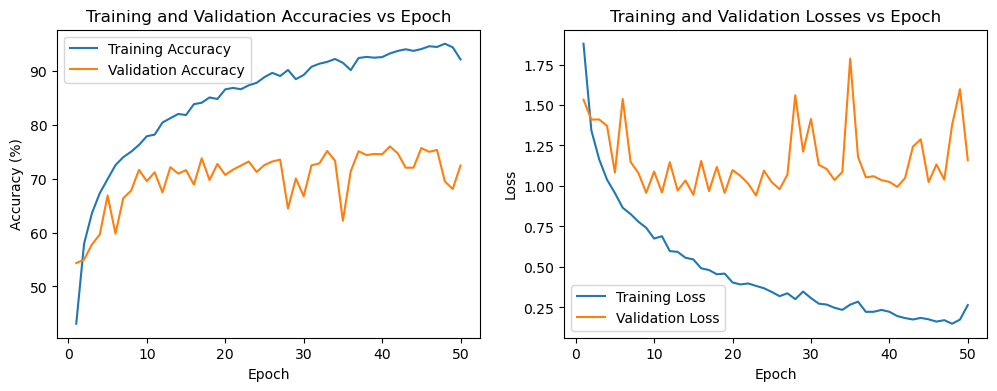

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import random

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
learning_rate = 0.001
num_classes = 20

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Randomly select 20 classes
selected_classes = random.sample(cifar100_classes, 20)

# Print the randomly selected classes
print("Randomly selected classes:")
print(selected_classes)

# CIFAR-100 dataset with 20 classes
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_dataset.data = [x for x, y in zip(train_dataset.data, train_dataset.targets) if y < num_classes]
train_dataset.targets = [y for y in train_dataset.targets if y < num_classes]

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataset.data = [x for x, y in zip(test_dataset.data, test_dataset.targets) if y < num_classes]
test_dataset.targets = [y for y in test_dataset.targets if y < num_classes]

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

model = ResNet18(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_correct_train = 0
    total_samples_train = 0
    total_loss_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy and loss during training
        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()
        total_loss_train += loss.item()

    # Calculate and store training accuracy and loss
    accuracy_train = 100 * total_correct_train / total_samples_train
    loss_train = total_loss_train / len(train_loader)
    train_accuracies.append(accuracy_train)
    train_losses.append(loss_train)

    # Validation loop
    model.eval()
    total_correct_val = 0
    total_samples_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track accuracy and loss during validation
            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted == labels).sum().item()
            total_loss_val += loss.item()

    # Calculate and store validation accuracy and loss
    accuracy_val = 100 * total_correct_val / total_samples_val
    loss_val = total_loss_val / len(test_loader)
    val_accuracies.append(accuracy_val)
    val_losses.append(loss_val)

    # Print progress
    print('Epoch [{}/{}], Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, '
          'Training Loss: {:.4f}, Validation Loss: {:.4f}'
          .format(epoch + 1, num_epochs, accuracy_train, accuracy_val, loss_train, loss_val))

# Plotting
epochs = range(1, num_epochs + 1)

# Plot training and validation accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies vs Epoch')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses vs Epoch')
plt.legend()

plt.show()

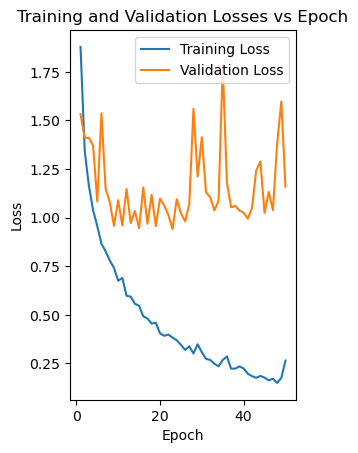

In [9]:
# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses vs Epoch')
plt.legend()

plt.show()

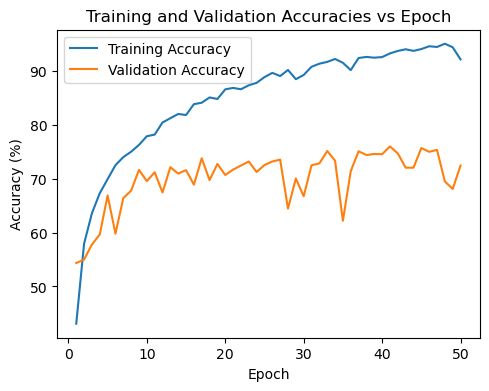

In [10]:
# Plot training and validation accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies vs Epoch')
plt.legend()

In [14]:

model.to(device)

ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [17]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [19]:
# Number of sets in the training set
num_train_sets = len(train_loader.dataset)
print("Number of sets in the training set:", num_train_sets)



# Number of sets in the test set
num_test_sets = len(test_loader.dataset)
print("Number of sets in the test set:", num_test_sets)

Number of sets in the training set: 10000
Number of sets in the test set: 2000
